In [ ]:
! pip install transformers datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine-tuning a model on a question-answering task

In [ ]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = True
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We used the [hugging face Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [ ]:
from datasets import load_dataset, load_metric

For our project here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset .

In [ ]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [ ]:
datasets["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly from the dataset and decoded back to strings.

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset
    ), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(
                lambda x: [typ.feature.names[i] for i in x]
            )
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,5730b096396df9190009629c,Sumer,"Though women were protected by late Sumerian law and were able to achieve a higher status in Sumer than in other contemporary civilizations, the culture was male-dominated. The Code of Ur-Nammu, the oldest such codification yet discovered, dating to the Ur-III ""Sumerian Renaissance"", reveals a glimpse at societal structure in late Sumerian law. Beneath the lu-gal (""great man"" or king), all members of society belonged to one of two basic strata: The ""lu"" or free person, and the slave (male, arad; female geme). The son of a lu was called a dumu-nita until he married. A woman (munus) went from being a daughter (dumu-mi), to a wife (dam), then if she outlived her husband, a widow (numasu) and she could then remarry.",How were women protected in Sumerian society?,"{'text': ['law'], 'answer_start': [45]}"
1,57321b1ae17f3d1400422697,Economy_of_Greece,"Between 1975 and 2009, Olympic Airways (known after 2003 as Olympic Airlines) was the country’s state-owned flag carrier, but financial problems led to its privatization and relaunch as Olympic Air in 2009. Both Aegean Airlines and Olympic Air have won awards for their services; in 2009 and 2011, Aegean Airlines was awarded the ""Best regional airline in Europe"" award by Skytrax, and also has two gold and one silver awards by the ERA, while Olympic Air holds one silver ERA award for ""Airline of the Year"" as well as a ""Condé Nast Traveller 2011 Readers Choice Awards: Top Domestic Airline"" award.","What airlines was award the ""Best regional airline in Europe"" award by Skytrax?","{'text': ['Aegean Airlines'], 'answer_start': [298]}"
2,57326001e99e3014001e673e,Dwight_D._Eisenhower,"Prior to his inauguration, Eisenhower led a meeting of advisors at Pearl Harbor addressing foremost issues; agreed objectives were to balance the budget during his term, to bring the Korean War to an end, to defend vital interests at lower cost through nuclear deterrent, and to end price and wage controls. Eisenhower also conducted the first pre-inaugural cabinet meeting in history in late 1952; he used this meeting to articulate his anti-communist Russia policy. His inaugural address, as well, was exclusively devoted to foreign policy and included this same philosophy, as well as a commitment to foreign trade and the United Nations.",Policy in regard to what country was discussed at Eisenhower's first cabinet meeting?,"{'text': ['Russia'], 'answer_start': [453]}"
3,572b8667111d821400f38ed5,Zinc,"Nearly two billion people in the developing world are deficient in zinc. In children it causes an increase in infection and diarrhea, contributing to the death of about 800,000 children worldwide per year. The World Health Organization advocates zinc supplementation for severe malnutrition and diarrhea. Zinc supplements help prevent disease and reduce mortality, especially among children with low birth weight or stunted growth. However, zinc supplements should not be administered alone, because many in the developing world have several deficiencies, and zinc interacts with other micronutrients.",Why shouldn't zinc be given alone to those with several deficiencies?,"{'text': ['zinc interacts with other micronutrients.'], 'answer_start': [560]}"
4,5acfdaa877cf76001a6862f9,Tibet,"Other pre-modern Chinese names for Tibet include Wusiguo (Chinese: 烏斯國; pinyin: Wūsīguó; cf. Tibetan dbus, Ü, [wyʔ˨˧˨]), Wusizang (Chinese: 烏斯藏; pinyin: wūsīzàng, cf. Tibetan dbus-gtsang, Ü-Tsang), Tubote (Chinese: 圖伯特; pinyin: Túbótè), and Tanggute (Chinese: 唐古忒; pinyin: Tánggǔtè, cf. Tangut). American Tibetologist Elliot Sperling has argued in favor of a recent tendency by some authors writing in Chinese to revive the term Tubote (simplified Chinese: 图伯特; traditional Chinese: 圖伯特; pinyin: Túbótè) for modern use in place of Xizang, on the grounds that Tubote more clearly includes the entire Tibetan plateau rather than simply the Tibet Autonomous Region.[citation need

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The following assertion ensures that our tokenizer is a fast tokenizer (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [ ]:
import transformers

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't in the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [ ]:
tokenizer("What is your name?", "My name is Nihaal.")

{'input_ids': [101, 1327, 1110, 1240, 1271, 136, 102, 1422, 1271, 1110, 27453, 2328, 1348, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [ ]:
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The allowed overlap between two part of the context when splitting is performed.

Let's find one long example in our dataset:

In [ ]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

Without any truncation, we get the following length for the input IDs:

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

437

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [ ]:
len(
    tokenizer(
        example["question"],
        example["context"],
        max_length=max_length,
        truncation="only_second",
    )["input_ids"]
)

384

Note that we never want to truncate the question, only the context, and so we use the `only_second` truncation method. Our tokenizer can automatically return a list of features capped by a certain maximum length, with the overlap we talked about above, we just have to tell it to do so with `return_overflowing_tokens=True` and by passing the stride:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride,
)

Now we don't have one list of `input_ids`, but several:

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 192]

And if we decode them, we can see the overlap:

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] beyonce got married in 2008 to whom? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included the suc

It's going to take some work to properly label the answers here: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride,
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 7), (8, 11), (12, 19), (20, 22), (23, 27), (28, 30), (31, 35), (35, 36), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 25), (26, 33), (34, 37), (38, 39), (39, 40), (41, 44), (45, 53), (54, 62), (63, 68), (69, 77), (78, 80), (81, 82), (83, 88), (89, 93), (93, 96), (97, 99), (100, 103), (104, 113), (114, 119), (120, 123), (124, 127), (128, 133), (134, 140), (141, 146), (146, 147), (148, 149), (150, 152), (152, 153), (153, 154), (154, 155), (156, 161), (162, 168), (168, 169), (170, 172), (173, 182), (182, 183), (183, 184), (185, 189), (190, 194), (195, 197), (198, 205), (206, 208), (208, 209), (210, 214), (214, 215), (216, 217), (218, 220), (220, 221), (221, 222), (222, 223), (224, 229), (230, 236), (237, 240), (241, 249), (250, 252), (253, 261), (262, 264), (264, 265), (266, 270), (271, 273), (274, 277), (278, 284), (285, 291), (291, 292), (293, 296), (297, 302), (303, 311), (312, 322), (323, 330), (330, 331), (331, 332), (333, 338), (339, 342), (343, 3

This gives the corresponding start and end character in the original text for each token in our input IDs. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(
    tokenizer.convert_ids_to_tokens([first_token_id])[0],
    example["question"][offsets[0] : offsets[1]],
)

beyonce Beyonce


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (
    offsets[token_start_index][0] <= start_char
    and offsets[token_end_index][1] >= end_char
):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while (
        token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char
    ):
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

18 19


And we can double check that it is indeed the correct answer:

In [ ]:
print(
    tokenizer.decode(
        tokenized_example["input_ids"][0][start_position : end_position + 1]
    )
)
print(answers["text"][0])

jay z
Jay Z


For this notebook to work with any kind of model, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [ ]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [ ]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
features = prepare_train_features(datasets["train"][:5])

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of the `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [ ]:
tokenized_datasets = datasets.map(
    prepare_train_features, batched=True, remove_columns=datasets["train"].column_names
)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `TFAutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [ ]:
from transformers import TFAutoModelForQuestionAnswering

model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To train our model, we will need to define a few more things. The first two arguments are to setup everything so we can push the model to the [Hub](https://huggingface.co/models) at the end of training. Remove the two of them if you didn't follow the installation steps at the top of the notebook, otherwise you can change the value of `push_to_hub_model_id` to something you would prefer.

We also tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

In [ ]:
model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-squad"
learning_rate = 2e-5
num_train_epochs = 10
weight_decay = 0.01

Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this - we can use the slightly more low-level [`Dataset.to_tf_dataset()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method, or we can use [`Model.prepare_tf_dataset()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset). The main difference between these two is that the `Model` method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. It also supplies a default data collator that will work fine for us, as our samples are already padded to the same length and ready to go.

In [ ]:
batch_size=32
train_set = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=batch_size,
)

validation_set = model.prepare_tf_dataset(
    tokenized_datasets["validation"],
    shuffle=False,
    batch_size=batch_size,
)

Next, we can create an optimizer and specify a loss function. The `create_optimizer` function gives us a very solid `AdamW` optimizer with weight decay and a learning rate schedule, but it needs us to compute the number of training steps to build that schedule.

In [ ]:
from transformers import create_optimizer

total_train_steps = len(train_set) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps
)

Note that most Transformers models compute loss internally, so we actually don't have to specify anything there! You can of course set your own loss function if you want, but by default our models will choose the 'obvious' loss that matches their task, such as cross-entropy in the case of language modelling. The built-in loss will also correctly handle things like masking the loss on padding tokens, or unlabelled tokens in the case of masked language modelling, so we recommend using it unless you're an advanced user!

In addition, because the outputs and loss for this model class are quite straightforward, we can use built-in Keras metrics - these are liable to misbehave in other contexts (for example, they don't know about the masking in masked language modelling) but work well here.

We can also use `jit_compile` to compile the model with [XLA](https://www.tensorflow.org/xla). In other cases, we should be careful about that - if our inputs might have variable sequence lengths, we may end up having to do a new XLA compilation for each possible length, because XLA compilation expects a static input shape! In this notebook, however, we have padded all examples to exactly the same length. This makes it perfect for XLA, which will give us a nice performance boost.

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer, jit_compile=True, metrics=["accuracy"])

/root


We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training). For now, let's just train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [ ]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

'''push_to_hub_callback = PushToHubCallback(
    output_dir="./qa_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)'''

tensorboard_callback = TensorBoard(log_dir="./qa_model_save/logs")

callbacks = [tensorboard_callback]

model.fit(
    train_set,
    validation_data=validation_set,
    epochs=num_train_epochs,
    callbacks=callbacks,
)



Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4117/4117 [==============================] - 1988s 469ms/step - loss: 1.5882 - end_logits_accuracy: 0.5414 - start_logits_accuracy: 0.5236 - val_loss: 1.4492 - val_end_logits_accuracy: 0.5465 - val_start_logits_accuracy: 0.5429
Epoch 2/10
4117/4117 [==============================] - 1861s 452ms/step - loss: 1.0442 - end_logits_accuracy: 0.6790 - start_logits_accuracy: 0.6586 - val_loss: 1.2418 - val_end_logits_accuracy: 0.6290 - val_start_logits_accuracy: 0.6239
Epoch 3/10
4117/4117 [==============================] - 1858s 451ms/step - loss: 0.8195 - end_logits_accuracy: 0.7460 - start_logits_accuracy: 0.7246 - val_loss: 1.2945 - val_end_logits_accuracy: 0.6303 - val_start_logits_accuracy: 0.6217
Epoch 4/10
4117/4117 [==============================] - 1868s 454ms/step - loss: 0.6601 - end_logits_accuracy: 0.7936 - start_logits_accuracy: 0.7720 - val_

In [ ]:
output_dir = "./fine_tuned_model"

# Save the fine-tuned model locally
model.save_pretrained(output_dir)

# Optionally, save the tokenizer as well
tokenizer.save_pretrained(output_dir)

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [ ]:
output_dir = "/content/drive/MyDrive/NPL_project/fine_tuned_model"

# Save the fine-tuned model locally
model.save_pretrained(output_dir)

# Optionally, save the tokenizer as well
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/NPL_project/fine_tuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/NPL_project/fine_tuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/NPL_project/fine_tuned_model/vocab.txt',
 '/content/drive/MyDrive/NPL_project/fine_tuned_model/added_tokens.json',
 '/content/drive/MyDrive/NPL_project/fine_tuned_model/tokenizer.json')

## Evaluation

Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and end position of our answers: if we take a batch from our validation dataset, here is the output our model gives us:

In [ ]:
batch = next(iter(validation_set))
output = model.predict_on_batch(batch)
output.keys()

odict_keys(['start_logits', 'end_logits'])

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [ ]:
output.start_logits.shape, output.end_logits.shape

((32, 384), (32, 384))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each feature is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [ ]:
import numpy as np

np.argmax(output.start_logits, -1), np.argmax(output.end_logits, -1)

(array([ 49,  37,  72,  80, 157,  17,  44,  85, 152, 202, 119,  52,  22,
         31,   0, 120, 250,  94,  90,  15,  87,  56,  88, 152,  23,   0,
          0, 138,  15,   0, 128,  30]),
 array([ 49,  40,  76,  81, 157,  19,  44,  86, 153, 204, 120,  52,  26,
         33,   0, 121, 252,  98,  91,  20,  91,  56,  94, 153,  24,   0,
          0, 142,  16,   0, 149,  23]))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [ ]:
n_best_size = 20

In [ ]:
import numpy as np

start_logits = output.start_logits[0]
end_logits = output.end_logits[0]
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "",  # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [ ]:
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our validation set easily:

In [ ]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

And turn the dataset into a `tf.data.Dataset` as before.

In [ ]:
validation_dataset = model.prepare_tf_dataset(
     validation_features,
     shuffle=False,
     batch_size=batch_size,
)

Now we can grab the predictions for all features by using the `model.predict` method:

In [ ]:
raw_predictions = model.predict(validation_dataset)

380/380 [==============================] - 52s 118ms/step


In [ ]:
raw_predictions

TFQuestionAnsweringModelOutput(loss=None, start_logits=array([[ -4.670161 , -10.182085 , -10.340337 , ..., -12.180876 ,
        -12.167004 , -12.163787 ],
       [ -8.104821 , -11.059164 , -11.525314 , ..., -12.193957 ,
        -12.179388 , -12.17708  ],
       [ -5.2449675, -10.315987 , -11.102616 , ..., -12.171593 ,
        -12.161625 , -12.166974 ],
       ...,
       [  9.841089 , -11.326865 , -11.412577 , ..., -12.209921 ,
        -12.211754 , -12.195017 ],
       [  7.100871 ,  -8.276945 , -10.071188 , ..., -12.260988 ,
        -12.212832 , -12.219654 ],
       [  8.910843 , -10.056166 , -10.764419 , ..., -12.196942 ,
        -12.181221 , -12.189076 ]], dtype=float32), end_logits=array([[ -4.69444  , -11.906998 , -11.363161 , ..., -12.084322 ,
        -12.0967865, -12.101889 ],
       [ -8.303815 , -10.82593  , -11.108619 , ..., -12.081227 ,
        -12.094144 , -12.096875 ],
       [ -4.935588 , -11.996576 , -11.718813 , ..., -12.092583 ,
        -12.101498 , -12.096516 ],
     

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0]
end_logits = output.end_logits[0]
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char:end_char],
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
    :n_best_size
]
valid_answers

[{'score': 18.94727, 'text': 'France'},
 {'score': 7.3604827, 'text': 'France.'},
 {'score': 5.9592247, 'text': 'a region in France'},
 {'score': 5.716701, 'text': 'in France'},
 {'score': 5.132899, 'text': 'Normandy, a region in France'},
 {'score': 4.5466304, 'text': 'region in France'},
 {'score': 2.246581,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark'},
 {'score': 2.2179828,
  'text': 'in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 1.5398579,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'},
 {'score': 1.125885,
  'text': 'gave their name to Normandy, a region in France'},
 {'score': 1.0907879,
  'text': '10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 0.2857933, 'text': 'name to Normandy, a region in France'},
 {'score': -0.051876068,
  'tex

We can compare to the actual ground-truth answer:

In [ ]:
datasets["validation"][0]["answers"]

{'text': ['France', 'France', 'France', 'France'],
 'answer_start': [159, 159, 159, 159]}

Our model's most likely answer is correct!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [ ]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(
    examples,
    features,
    all_start_logits,
    all_end_logits,
    n_best_size=20,
    max_answer_length=30,
):
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[
                -1 : -n_best_size - 1 : -1
            ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or not offset_mapping[start_index]
                        or not offset_mapping[end_index]
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = (
                best_answer["text"] if best_answer["score"] > min_null_score else ""
            )
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [ ]:
final_predictions = postprocess_qa_predictions(
    datasets["validation"],
    validation_features,
    raw_predictions["start_logits"],
    raw_predictions["end_logits"],
)

Post-processing 11873 example predictions split into 12134 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

Then we can load the metric from the datasets library.

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

<ipython-input-55-69495f532713>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2" if squad_v2 else "squad")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for squad_v2 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/squad_v2/squad_v2.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Then we can call compute on it. We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument (which we set to 0.0 here as we have already set the answer to empty if we picked it).

In [ ]:
if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 63.80021898424998,
 'f1': 67.9405797162126,
 'total': 11873,
 'HasAns_exact': 65.9919028340081,
 'HasAns_f1': 74.28449780205634,
 'HasAns_total': 5928,
 'NoAns_exact': 61.6148023549201,
 'NoAns_f1': 61.6148023549201,
 'NoAns_total': 5945,
 'best_exact': 63.80021898424998,
 'best_exact_thresh': 0.0,
 'best_f1': 67.94057971621284,
 'best_f1_thresh': 0.0}

If you ran the callback above, you can now share this model with all your friends, family or favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import TFAutoModelForQuestionAnswering

model = TFAutoModelForQuestionAnswering.from_pretrained("your-username/my-awesome-model")
```

## Inference

Now, let's get some sample text and ask a question. Feel free to substitute your own text and question!

In [3]:
context = """The dominant sequence transduction models are based on complex recurrent or convolutional
neural networks in an encoder-decoder configuration. The best performing models also connect the encoder
and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on
two machine translation tasks show these models to be superior in quality while being more parallelizable
and requiring significantly less time to train."""
question = "What is the proposed arcitecture?"


In [5]:
context2 = """ My name is vamsi. I was born in 2001. I am a student at University of Delaware.
 I am a international student from India. we are doing this project as part of our NLP class"""
question2 = "when did he born?"

context3 = """Hello my name is Nihaal and my teammate is vamsi. we implemented Question and answering model as part of our NLP project
we used tensorflow frame work to train and test the model. we also took reference from hugging face to make our code work"""
question3 = "what frame work they used?"



## Pipeline API

To quickly perform inference with the model we used [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above. It will perform the preprocessing, forward pass and postprocessing all in a single object.

Let's showcase this for our trained model:

In [6]:
from transformers import pipeline

question_answerer = pipeline("question-answering",  "/content/drive/MyDrive/NPL_project/fine_tuned_model", framework="tf")


Some layers from the model checkpoint at /content/drive/MyDrive/NPL_project/fine_tuned_model were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at /content/drive/MyDrive/NPL_project/fine_tuned_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g

In [7]:
question_answerer(context=context, question=question)

{'score': 0.13466757535934448,
 'start': 285,
 'end': 300,
 'answer': 'the Transformer'}

In [8]:
question_answerer(context=context2, question=question2)

{'score': 0.5556483864784241, 'start': 33, 'end': 37, 'answer': '2001'}

In [9]:
question_answerer(context=context3, question=question3)

{'score': 0.9700524210929871, 'start': 129, 'end': 139, 'answer': 'tensorflow'}

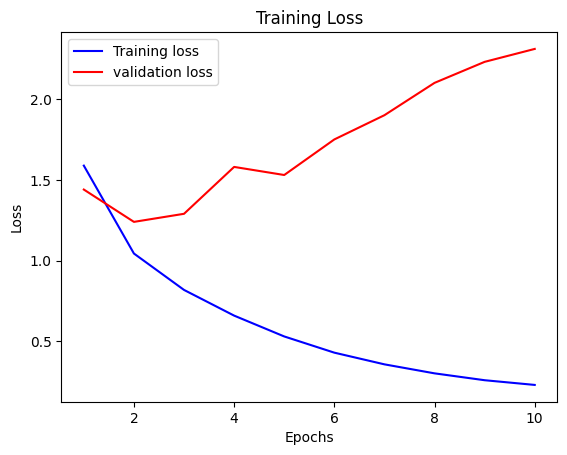

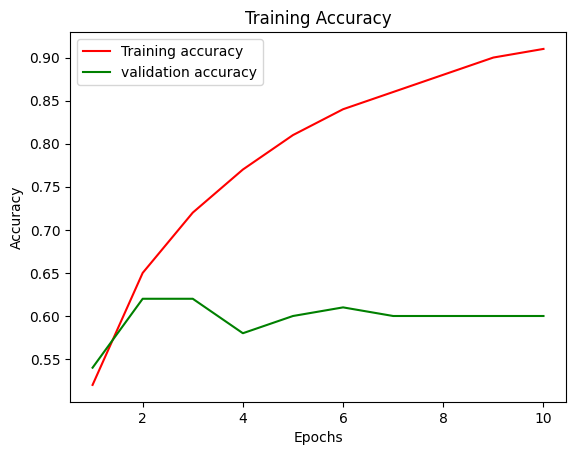

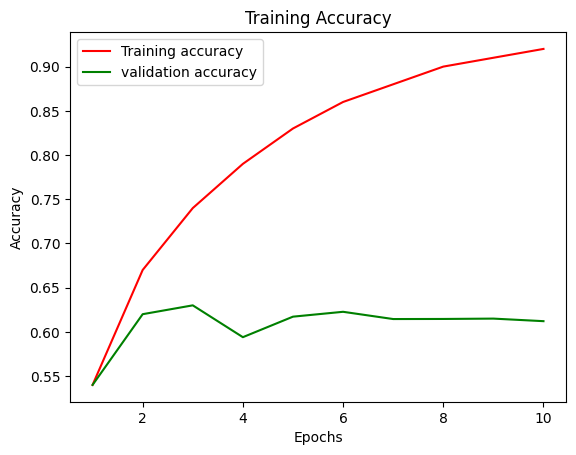

In [ ]:
#training
loss=[1.588,1.0442,0.819,0.6601,0.5312,0.4309,0.3586,0.3029,0.2604,0.2313]
star_logits_acc= [0.52,0.65,0.72,0.77,0.81,0.84,0.86,0.88,0.90,0.91]
end_logits_acc= [0.54,0.67,0.74,0.79,0.83,0.86,0.88,0.90,0.91,0.92]
#validation
val_loss=[1.44,1.24,1.29,1.58,1.53,1.75,1.90,2.10,2.23,2.31]
start_logi_val_acc= [0.54,0.62,0.62,0.58,0.60,0.61,0.60,0.60,0.60,0.60]
end_logi_val_acc= [0.54,0.62,0.63,0.5940,0.6172,0.6227,0.6145,0.6146,0.6150,0.6121]
epochs = range(1, len(loss) + 1)

import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, star_logits_acc, 'r', label='Training accuracy')
plt.plot(epochs, start_logi_val_acc, 'g', label='validation accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, end_logits_acc, 'r', label='Training accuracy')
plt.plot(epochs, end_logi_val_acc, 'g', label='validation accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

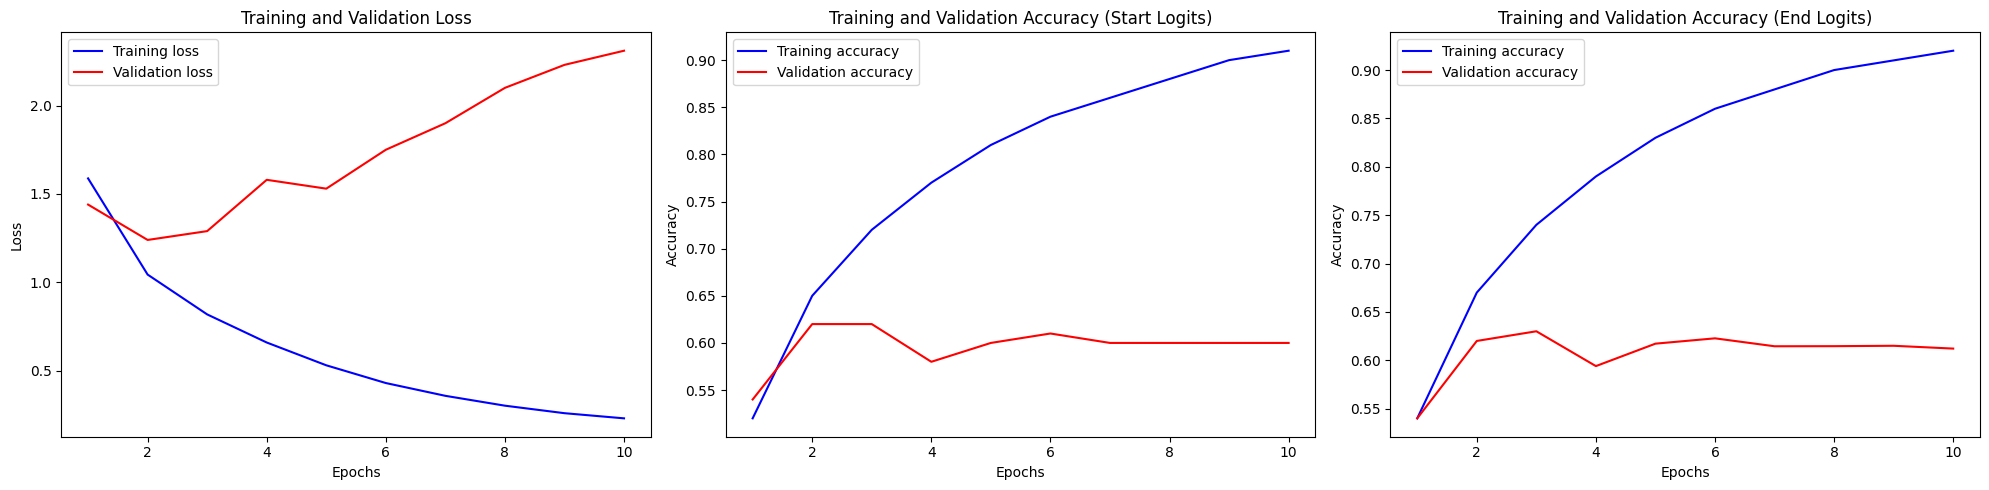

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(loss) + 1)
loss = [1.588, 1.0442, 0.819, 0.6601, 0.5312, 0.4309, 0.3586, 0.3029, 0.2604, 0.2313]
val_loss = [1.44, 1.24, 1.29, 1.58, 1.53, 1.75, 1.90, 2.10, 2.23, 2.31]
star_logits_acc = [0.52, 0.65, 0.72, 0.77, 0.81, 0.84, 0.86, 0.88, 0.90, 0.91]
end_logits_acc = [0.54, 0.67, 0.74, 0.79, 0.83, 0.86, 0.88, 0.90, 0.91, 0.92]
start_logi_val_acc = [0.54, 0.62, 0.62, 0.58, 0.60, 0.61, 0.60, 0.60, 0.60, 0.60]
end_logi_val_acc = [0.54, 0.62, 0.63, 0.5940, 0.6172, 0.6227, 0.6145, 0.6146, 0.6150, 0.6121]

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot Training and Validation Loss
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Training and Validation Accuracy for start logits
axs[1].plot(epochs, star_logits_acc, 'b', label='Training accuracy')
axs[1].plot(epochs, start_logi_val_acc, 'r', label='Validation accuracy')
axs[1].set_title('Training and Validation Accuracy (Start Logits)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot Training and Validation Accuracy for end logits
axs[2].plot(epochs, end_logits_acc, 'b', label='Training accuracy')
axs[2].plot(epochs, end_logi_val_acc, 'r', label='Validation accuracy')
axs[2].set_title('Training and Validation Accuracy (End Logits)')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
